# Apply Homography to Labels

In [1]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", "ChartExtractor", "src"))

In [9]:
import json
import random
from PIL import Image, ImageDraw
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm
# Created a folder utils in the conversion folder and moved these files into there so we can call their functions
# There should be a better way to do this perhaps, if this is something we will use across various microservices
# Perhaps they can be a part of a package.
from utils.annotations import BoundingBox, Point
from utils.image_conversion import pil_to_cv2, cv2_to_pil


import cv2
import numpy as np
import pandas as pd

In [10]:
from operator import attrgetter

In [11]:
Point.__repr__ = lambda self: f"Point({self.x}, {self.y})"

---

## 1 - Load Data

In [12]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    """Loads data from LabelStudio's json format into BoundingBoxes."""
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/".."/"data"
landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")
checkbox_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_checkbox_names.json")

This is a slightly different version of the homography function from the main program. The only thing it changes is to return the homography matrix along with the image.

In [13]:
def homography_transform(
    src_image: Image.Image,
    src_points: List[Tuple[float, float]],
    dest_points: List[Tuple[float, float]],
    original_image_size: Tuple[float, float] = (3300, 2250),
) -> Tuple[List[List[float]], Image.Image]:
    """Performs homography transformation on an image.

    This function transforms an image (src_image) based on corresponding points
    between the source and destination images. It calculates the homography matrix
    and uses it to warp the source image to the perspective of the destination points.

    Args:
        src_image (Image.Image):
            A PIL image object representing the source image.
        src_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the source image that correspond
            to points in the destination image.
        dest_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the destination image that points
            in the source image correspond to (where the source image should be warped to).
        original_image_size (Tuple[float, float]):
            A tuple (width, height) representing the size of the control image.
            Defaults to (3300, 2250).

    Returns:
        A PIL image object representing the transformed source image.

    Raises:
        ValueError:
            If the length of src_points and dest_points don't match (must have the same
            number of corresponding points), or if there are less than 4 points.
    """
    src_points: np.ndarray = np.array(src_points)
    dest_points: np.ndarray = np.array(dest_points)

    if len(src_points) != len(dest_points):
        raise ValueError(
            "Source and destination points must have the same number of elements."
        )
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("Must have 4 or more points to compute the homography.")

    src_image = pil_to_cv2(src_image)
    h, _ = cv2.findHomography(src_points, dest_points)
    dest_image = cv2.warpPerspective(src_image, h, original_image_size)
    return h, cv2_to_pil(dest_image)

In [14]:
def get_corresponding_points(bboxes, imsize) -> List[Tuple[float, float]]:
    """Gets and sorts the points used for the homography from all the bounding boxes that are labeled."""
    categories_to_get = ['anesthesia_start', 'lateral', 'safety_checklist', 'units']
    if not all([c in [bb.category for bb in bboxes] for c in categories_to_get]):
        raise ValueError(f"Necessary labels not found: {categories_to_get}")
    
    points = list(map(
        attrgetter('center'),
        sorted(
            list(filter(lambda bb: bb.category in categories_to_get, bboxes)), 
            key=lambda bb: bb.category
        )
    ))
    return [(p[0]*imsize[0], p[1]*imsize[1]) for p in points]

In [31]:
remap_point = lambda p, h: cv2.perspectiveTransform(np.array(p, dtype=np.float32).reshape(-1, 1, 2), h).tolist()[0][0]


def remap_bbox(
    bbox: BoundingBox, 
    homography_matrix: List[List[float]], 
    original_width:int=4032, 
    original_height:int=3024,
    new_width:int=3300,
    new_height:int=2250,
) -> BoundingBox:
    """Maps boundingboxes to a new space using the homography matrix.
    
    Given a bounding box, homography matrix, and the image sizes of the original 
    and destination (new) image, this function returns a remapped bounding box.
    """
    new_left, new_top = remap_point((bbox.left*original_width, bbox.top*original_height), homography_matrix)
    new_right, new_bottom = remap_point((bbox.right*original_width, bbox.bottom*original_height), homography_matrix)
    return BoundingBox(bbox.category, new_left/new_width, new_top/new_height, new_right/new_width, new_bottom/new_height)


remap_all_bboxes = lambda bboxes, h: [remap_bbox(bb, h) for bb in bboxes]

print(landmark_location_data.keys())
for sheet in landmark_location_data:
    print(f"Sheet: {sheet}")

    locations = landmark_location_data[sheet]
    print(f"Locations for {sheet}: {locations}")

    try:
        image = Image.open(data_path/f"chart_images/{sheet}")
        print(f"Able to obtain image. Image: {image}")
    except:
        print(f"Unable to obtain image for sheet {sheet}. Likely in main directory and png format.")
        continue
    
    h, pil_img = homography_transform(
        src_image=image,
        src_points=get_corresponding_points(locations, (4032, 3024)),
        dest_points=[(0, 0), (3300, 2250), (0, 2250), (3300, 0)]
    )

    print(f"Homography matrix: {h}")

    remapped_locations = remap_all_bboxes(locations, h)

    print(f"Remapped locations: {remapped_locations}")

    # View the image
    pil_img.show()

    break

dict_keys(['unified_intraoperative_preoperative_flowsheet_v1_1_front.png', 'RC_0001_intraoperative.JPG', 'RC_0002_intraoperative.JPG', 'RC_0003_intraoperative.JPG', 'RC_0004_intraoperative.JPG', 'RC_0005_intraoperative.JPG', 'RC_0006_intraoperative.JPG', 'RC_0007_intraoperative.JPG', 'RC_0008_intraoperative.JPG', 'RC_0009_intraoperative.JPG', 'RC_0010_intraoperative.JPG', 'RC_0011_intraoperative.JPG', 'RC_0012_intraoperative.JPG', 'RC_0013_intraoperative.JPG', 'RC_0014_intraoperative.JPG', 'RC_0015_intraoperative.JPG', 'RC_0016_intraoperative.JPG', 'RC_0017_intraoperative.JPG', 'RC_0018_intraoperative.JPG', 'RC_0019_intraoperative.JPG'])
Sheet: unified_intraoperative_preoperative_flowsheet_v1_1_front.png
Locations for unified_intraoperative_preoperative_flowsheet_v1_1_front.png: [BoundingBox(category='anesthesia_start', left=0.01272509471128841, top=0.0074461197571953, right=0.07575473602069113, bottom=0.016866305933318605), BoundingBox(category='units', left=0.9460597274343558, top=0.

KeyboardInterrupt: 

Get landmarks that show up only once.

Check labels.

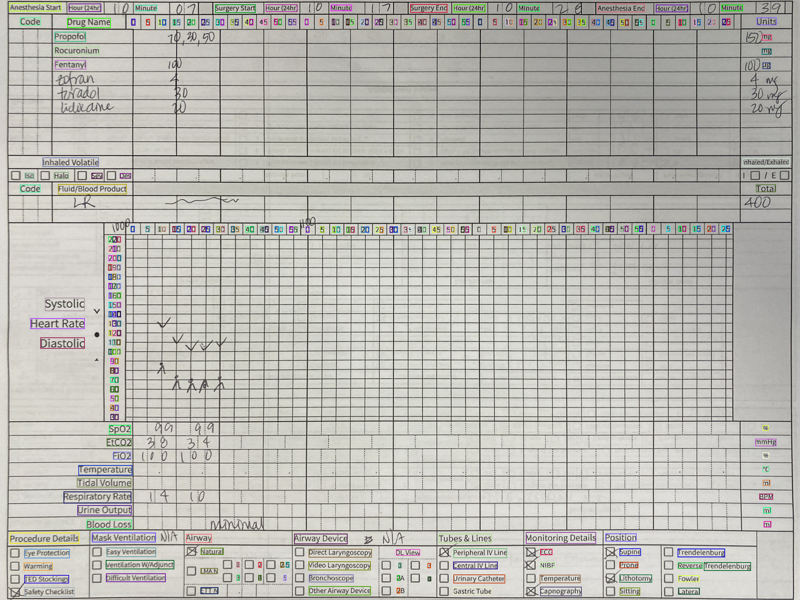

In [32]:
generate_color = lambda: "#%06x" % random.randint(0, 0xFFFFFF)

sheet = "RC_0001_intraoperative.JPG"
img = Image.open(str(data_path/"chart_images"/sheet))
original_width, original_height = img.size
img = transformed_img.copy()
width, height = img.size
draw = ImageDraw.Draw(img)

for bounding_box in remapped_locations:
    box = [
        bounding_box.left*width,
        bounding_box.top*height,
        bounding_box.right*width,
        bounding_box.bottom*height,
    ]
    draw.rectangle(box, outline=generate_color(), width=3)
img.resize((800, 600))

In [ ]:
# dump your BoundingBoxes to the format of your choosing here.